In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly     

In [3]:
df = pd.read_csv("players_21.csv", error_bad_lines=False)

C:\Users\pirat\AppData\Local\Temp\ipykernel_16456\2096527566.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("players_21.csv", error_bad_lines=False)


# Data Preprocessing & Feature Engineering

In [4]:
# Drop Unnecessary columns
df = df.drop(['sofifa_id', 'player_url', 'long_name', 'body_type', 'real_face', 'loaned_from', 'nation_position', 'nation_jersey_number'], axis=1)

### 1: Position Columns
Clean, Process and Assign the new attributes to columns listed below. These columns will be used to identify best alternate playing position based on ratings:
<br>
'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'

In [4]:
stats = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb']
for col in stats:
    new = df[col].str.split("+", n=1, expand=True)
    df[col] = new[0]

# Replace NaN with 0
df[stats] = df[stats].fillna(0)
df[stats] = df[stats].astype(int)

### 2: Player's Work Rate
Convert the categorical values in Work Rate column in integer values. These columns are used to identify players work rate in offense and defence. Having one-hot encoding them provides us to use these features in further analysis and recommendations.

In [5]:
# Create dummy variables and append to dataframe
df = pd.concat([df, pd.get_dummies(df['work_rate'])], axis=1)
# Drop original work_rate column
df = df.drop(['work_rate'], axis=1)


### 3: Player's DOB
Clean and fetch the month value from dob column to use for analysis.

In [6]:
# Split the dob column to fetch month
new = df_20["dob"].str.split("-", n = 2, expand = True)
df_20["birth_month"] = new[1].astype(int)

### 4: Player's Position
Convert the categorical values in Player's Position column in integer values. These columns are used to identify players playing positions (single-multi). Having one-hot encoding them provides us to use these features in further analysis and recommendations.

In [7]:
df = pd.concat([df, df['player_positions'].str.get_dummies(sep=', ').add_prefix('Position_')], axis=1) 
# Drop original work_rate column
df = df.drop(['player_positions'], axis=1)

### 5. BMI: New feature creation
Creation of a BMI feature using Weight_kg & Height_cm and use it instead of 'body_type' feature.

In [9]:
# Check the missing values in the column
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index(drop=False)
missing_data = missing_data.rename(columns={"index": "Columns", 0: "Value"})
missing_data['Proportion'] = (missing_data['Value'] / len(df)) * 100

# Recommend Alternate Playing Position per Player
Display alternate playing positions of a player which are not current playing positions of the player. <br>
*For Goalkeepers alternate playing position will have 0 ratings*

In [29]:
import re

def alternate_position(player, df):
    # Get player's index
    idx = df[df['short_name'] == player].index[0]
    sample_1 = df.iloc[:, 68:94]
    # Find 5 highest scores per position of player
    ls = sample_1.loc[idx].nlargest(5).index[0:].values
    ls = ls.tolist()
    sample_2 = df.iloc[idx, 104:119]
    # Identify positions which are not current playing positions
    ls2 = sample_2[sample_2 == 1].index[:].values
    # Make index values lower case
    ls2 = list(map(lambda x: x.lower(), ls2.tolist()))
    ls2 = [re.sub(r'position_', '', i) for i in ls2]
    # Find Positions with highest rating and are not currently playing positions
    alt_pos = set(ls) - (set(ls2))
    print("Alternate Playing Positions for {} are".format(player))
    for i in alt_pos:
        print("Position: {}, Rating: {}".format(str.upper(i), df[i].values[idx]))
    return None


### Test 1: P. Pogba

In [30]:
alternate_position("P. Pogba", df)

Alternate Playing Positions for P. Pogba are
Position: LAM, Rating: 84
Position: RAM, Rating: 84
Position: LCM, Rating: 84
Position: CAM, Rating: 84


### Test 2: M. Salah

In [31]:
alternate_position('M. Salah', df)

Alternate Playing Positions for M. Salah are
Position: LF, Rating: 88
Position: RF, Rating: 88
Position: LW, Rating: 88
Position: CF, Rating: 88


# Player Recommendation

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

### 1: Fetch numeric columns

In [33]:
sample = df.select_dtypes(include='number')
print(sample.head())

   age  height_cm  weight_kg  overall  potential  value_eur  wage_eur  \
0   32        170         72       94         94   95500000    565000   
1   34        187         83       93         93   58500000    405000   
2   27        175         68       92         92  105500000    290000   
3   26        188         87       91         93   77500000    125000   
4   28        175         74       91         91   90000000    470000   

   international_reputation  weak_foot  skill_moves  ...  Position_LM  \
0                         5          4            4  ...            0   
1                         5          4            5  ...            0   
2                         5          5            5  ...            0   
3                         3          3            1  ...            0   
4                         4          4            4  ...            0   

   Position_LW  Position_LWB  Position_RB  Position_RM  Position_RW  \
0            0             0            0          

### 2: Correlation Matrix

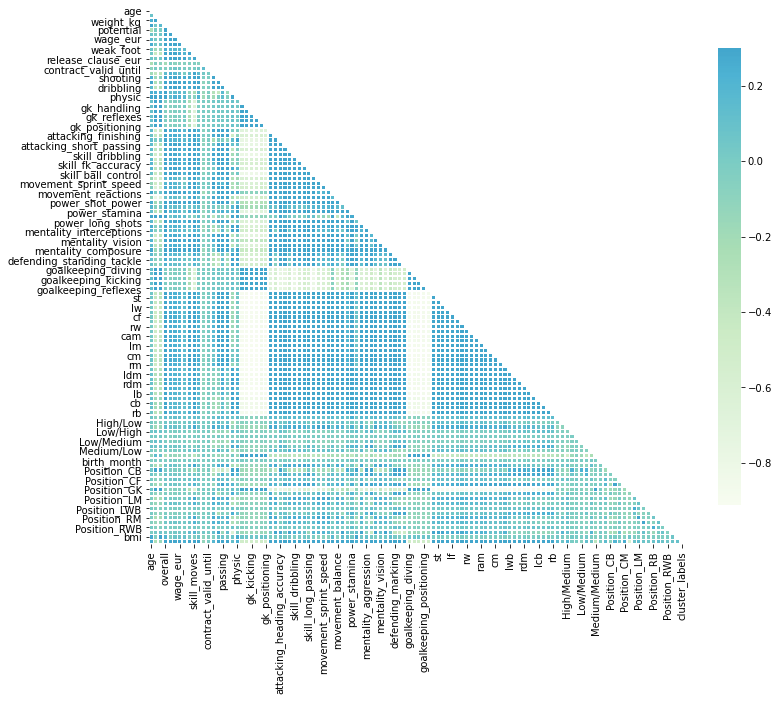

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,12))

# Compute the correlation matrix
corr = sample.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="GnBu", vmax=.3, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .7})

From the above correlation chart, we can see a lot of Goalkeepers attributes have a negative correlation with the attributes possessed by a Forward, Midfielder and Defender.

### 3: Standardize, implement NearestNeighbors generate 5 similar players

In [35]:
scaled = StandardScaler()
X = scaled.fit_transform(sample)
recommendations = NearestNeighbors(n_neighbors=6,algorithm='kd_tree')
recommendations.fit(X)
player_index = recommendations.kneighbors(X)[1]


In [36]:
# Define a function to get Player's Index
def get_index(x):
    return df[df['short_name']==x].index.tolist()[0]

# Fetch 5 indexes of similar players
def recommend_similar(player):
    print("These are 5 players similar to {} : ".format(player))
    index=  get_index(player)
    for i in player_index[index][1:]:
        print("Name: {}\nOverall: {}\nMarket Value: {}\nAge: {}\n".format(df_20.iloc[i]['short_name'],df_20.iloc[i]['overall'], df_20.iloc[i]['value_eur'], df_20.iloc[i]['age']))

### Test 1: Eden Hazard

In [37]:
recommend_similar('E. Hazard')

These are 5 players similar to E. Hazard : 
Name: A. Griezmann
Overall: 89
Market Value: 69000000
Age: 28

Name: L. Messi
Overall: 94
Market Value: 95500000
Age: 32

Name: Neymar Jr
Overall: 92
Market Value: 105500000
Age: 27

Name: K. De Bruyne
Overall: 91
Market Value: 90000000
Age: 28

Name: R. Sterling
Overall: 88
Market Value: 73000000
Age: 24



### Test 2: J. Gomez

In [38]:
recommend_similar('J. Gomez')

These are 5 players similar to J. Gomez : 
Name: M. Holgate
Overall: 75
Market Value: 8000000
Age: 22

Name: N. Mukiele
Overall: 77
Market Value: 12000000
Age: 21

Name: B. Pavard
Overall: 79
Market Value: 15500000
Age: 23

Name: A. Tuanzebe
Overall: 73
Market Value: 6500000
Age: 21

Name: N. Elvedi
Overall: 78
Market Value: 13000000
Age: 22

